In [1]:
%%HTML
<style>
    div#notebook-container    { width: 100%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>

import importlib
importlib.reload(util)

In [2]:
import raceresults
import dataprepare
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.reset_default_graph()
os.environ['KMP_DUPLICATE_LIB_OK']='True'
        
# レース情報
race_results_obj = raceresults.RaceResults()
data_prepare_obj = dataprepare.DataPrepare()
data_prepare_obj.data_prepare(race_results_obj.get_results_pd(), True)
_X, _y = data_prepare_obj.get_prepared_data()
X = _X.values
y = _y.values

In [3]:
def build_model():
  model = keras.Sequential([
    layers.Dense(10, activation='elu', input_shape=[len(_X.keys())]),
    layers.Dense(10, activation='elu'),
    layers.Dense(10, activation='elu'),
    layers.Dense(10, activation='elu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [4]:
model = build_model()

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                15590     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 15,931
Trainable params: 15,931
Non-trainable params: 0
_________________________________________________________________


In [6]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 100

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(X, y, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])


............

In [7]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
7,7.350000,1.816102,7.350000,7.095787,1.834435,7.095787,7
8,7.194060,1.800646,7.194060,7.087952,1.833759,7.087952,8
9,7.077631,1.798023,7.077631,7.084263,1.832643,7.084263,9
10,7.393926,1.970412,7.393926,7.070825,1.830842,7.070825,10
11,7.126476,1.799558,7.126476,7.051165,1.825506,7.051165,11


In [8]:
import matplotlib.pyplot as plt
import pathlib

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,100])
  plt.legend()
  plt.show()

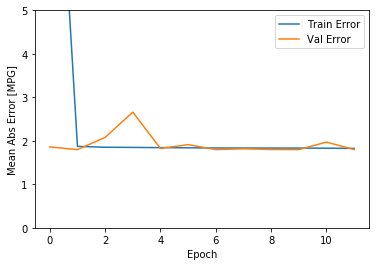

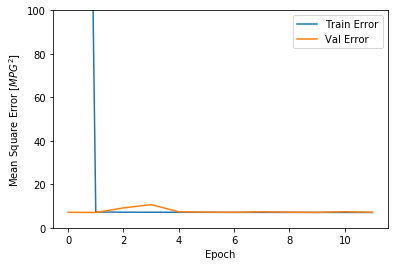

In [9]:
plot_history(history)

In [10]:
model.save('my_model.h5')

In [47]:
model_for_test = keras.models.load_model('my_model.h5')
predict_data = [(107.5, '4189', '江戸川', 1800, 1, 6.44, '2020-02-02')\
                , (107.5, '4357', '江戸川', 1800, 2, 6.51, '2020-02-02')\
                , (107.5, '4993', '江戸川', 1800, 3, 6.60, '2020-02-02')\
                , (107.5, '3548', '江戸川', 1800, 4, 6.63, '2020-02-02')\
                , (107.5, '4558', '江戸川', 1800, 5, 6.62, '2020-02-02')\
                , (107.5, '4411', '江戸川', 1800, 6, 6.60, '2020-02-02')]
predict_data_pd = pd.DataFrame(predict_data, columns=raceresults.COLUMN_LIST)

data_prepare_obj.data_prepare(predict_data_pd, False)
_X, _y = data_prepare_obj.get_prepared_data()

b = model.predict(_X.values)

In [48]:
pd.set_option('display.max_columns', 10000)

In [49]:
_X

COURSE  4715  4342  5017  3286  4365  3257  4445  3831  4581  3231  4047  \
0       1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1       2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2       3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3       4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4       5   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
5       6   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   4463  4061  4138  3548  5008  3839  3997  4213  3630  4079  4751  4692  \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
5   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   4325  4522  4705  4802  4796  3951  3563  4755  3044  3776  4306  4724  \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
5   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   4301  4276  4750  4218  4035  4543  4314  4737  4643  3251  4566  4446  \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
5   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   4070  4413  4448  4757  4172  3966  4760  4688  4049  4787  4148  4504  \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
5   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   4308  4545  4171  4019  4296  3788  4759  4074  4099  4067  4659  3590  \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
5   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   3959  4524  3960  3388  3415  3854  4262  4391  4238  3783  4344  4547  \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
5   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   3744  4168  4371  4364  4468  4030  4324  4644  3561  3471  4896  3491  \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0

In [50]:
b

array([[112.1153 ],
       [112.9866 ],
       [116.16207],
       [113.40455],
       [114.55601],
       [114.26595]], dtype=float32)